In [7]:
import numpy as np
import matplotlib.pyplot as plt
from main import *
import math
%matplotlib inline

# Two Source PET Reconstruction

First we load the data and initiate the angles for which we scanned the radioactive sources.

In [8]:
data = np.loadtxt('./data/Lastscan.csv',delimiter=",")   

angle_step = 10
angles=np.arange(0,len(data)*angle_step,angle_step)
print('Angles:',angles)

Angles: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180]


In [9]:
angle_step = 10
angles=np.arange(0,len(data)*angle_step,angle_step)
print('Angles:',angles)

Angles: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180]


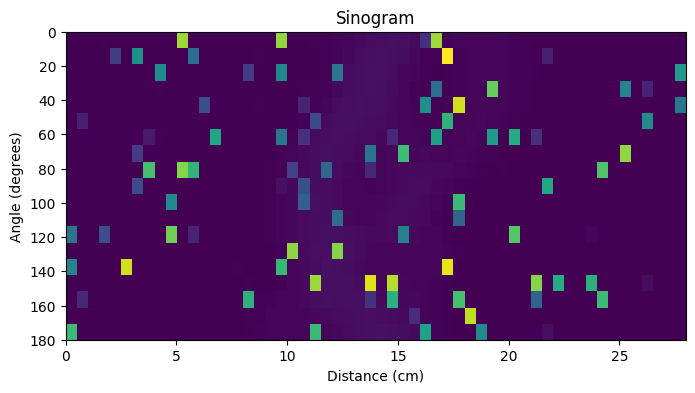

In [10]:
fig,ax = plt.subplots(figsize = (8,4))
start_dist = 0
end_dist = 28
start_angle = 0
end_angle = angles[-1]  # This is the last angle in the array, no matter how many angles are in it.
ax.imshow(data,extent=[start_dist,end_dist,end_angle,start_angle],aspect="auto")
ax.set_xlabel("Distance (cm)")
ax.set_ylabel("Angle (degrees)")
ax.set_title("Sinogram");

The image reconstruction for the above sinogram (shown below) is clearly too messy for any productive understanding of the emission source configurations. We're going to need to do some cleaning up to understand anything.

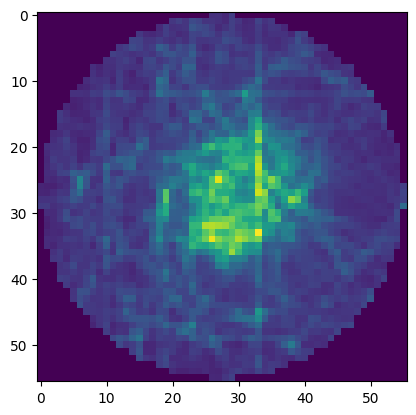

In [46]:
from scipy import ndimage
expand_vec = np.ones(data[0].size)
expanded_data = []
for item in data:
    expanded_data.append(np.outer(expand_vec,item))

rotated_data = []
for index, item in enumerate(expanded_data):
    rotated_data.append(ndimage.rotate(item,angles[index],reshape=False,order=1)) # we want Numpy to keep our square, 2d matricies.

composite = np.ones_like(rotated_data[0])
for item in rotated_data:
    composite *= item
normalized = np.power(composite,(1/len(rotated_data))) #

fig, ax = plt.subplots()
ax.imshow(normalized)

Here, we do some preliminary cutoff for some threshold value for erroneous data points. We then smooth out the data using local averages

In [48]:
def smear(array,x,y):
    adjacent = []
    xsequence = [-1,-1,-1,0,0,1,1,1]
    ysequence = [-1,0,1,-1,1,-1,0,1]
    for index,item in enumerate(xsequence):
        try:
            adjacent.append(array[x+xsequence[index]][y+ysequence[index]])
        except:
            pass
    return np.median(adjacent)

cutoff_threshold = 1.5e4
data2 = np.zeros_like(data)
for i in range(len(data)):
    for j in range(len(data[0])):
        if(data[i][j]>cutoff_threshold ):
            data2[i][j] = smear(data,i,j)
        else:
            data2[i][j] = data[i][j]
data = data2

Like the two source setup up, we expand the discrete signal data and project it onto a square matrix for each angle. This is done for each angle and stacked into one image. After some cleanup and data processing, the overlap of these matrix yields the location of emission source. The projected matrix for the first and third angles is shown below, and the full overlayed matrix is below that.

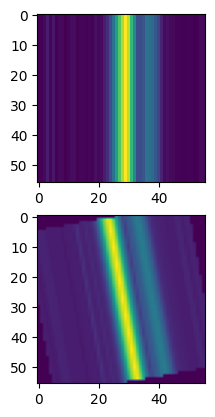

In [50]:
expand_vec = np.ones(data[0].size)  # this is used to get us a square matrix
expanded_data = []
for item in data:
    expanded_data.append(np.outer(expand_vec,item))

rotated_data = []
for index, item in enumerate(expanded_data):
    rotated_data.append(ndimage.rotate(item,angles[index],reshape=False,order=1)) # we want Numpy to keep our square, 2d matricies.
    
fig, (ax,ay) = plt.subplots(2)
ax.imshow(rotated_data[0])
ay.imshow(rotated_data[1])


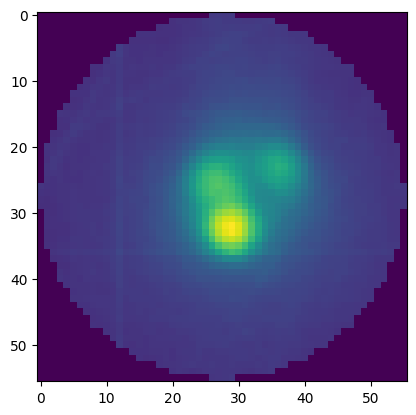

In [51]:
composite = np.ones_like(rotated_data[0])
for item in rotated_data:
    composite *= item
normalized = np.power(composite,(1/len(rotated_data))) #

fig, ax = plt.subplots()
ax.imshow(normalized)

We then do some final smoothing out to prevent the findpeaks package from mistakingly picking up local maxima and minima. The final product is a much more accurate reconstruction with much better resolution without changing anything about the physical setup.

In [52]:
smoothingFunction(rotated_data,50)

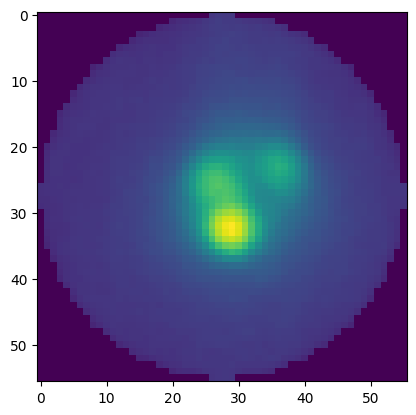

In [53]:
composite = np.ones_like(rotated_data[0])
for item in rotated_data:
    composite *= item
normalized = np.power(composite,(1/len(rotated_data))) #

fig, ax = plt.subplots()
ax.imshow(normalized)

[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [3].
[findpeaks] >Detect peaks using topology method with limit at None.
[findpeaks] >Detect peaks using topology method with limit at None.
[findpeaks] >Fin.


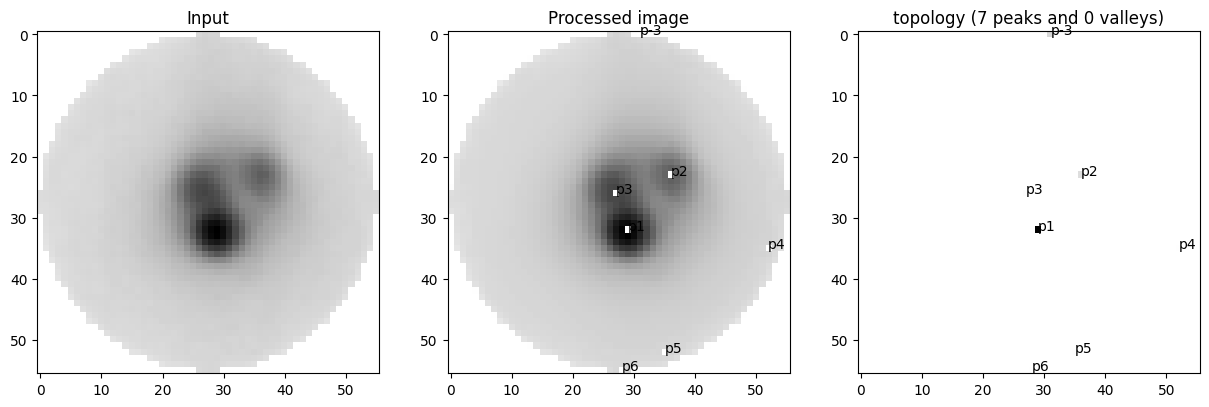

(<AxesSubplot:title={'center':'Input'}>,
 <AxesSubplot:title={'center':'Processed image'}>,
 <AxesSubplot:title={'center':'topology (7 peaks and 0 valleys)'}>)

In [54]:
from findpeaks import findpeaks

fp = findpeaks(method='topology')
results = fp.fit(normalized)
fp.plot()

In [55]:
results['persistence'].head()

,x,y,birth_level,death_level,score,peak,valley
0,29,32,255.0,0.0,255.0,True,False
1,36,23,160.0,127.0,33.0,True,False
2,27,26,186.0,183.0,3.0,True,False
3,52,35,44.0,43.0,1.0,True,False
4,35,52,43.0,42.0,1.0,True,False


In [56]:
x = []
step = 0.5
while step <= 28:
    x.append(step)
    step += 0.5

x = np.array(x)
x

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5,
       17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. ,
       22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5,
       28. ])

We can then use some Gaussian function data fitting to most accurately identify the locations of each emission source. This gives us the confidence interval for each obtained location value.

In [57]:
xcoord = results['persistence'].iloc[0]['x']
ycoord = results['persistence'].iloc[0]['y']
print(xcoord,ycoord)
featureIdentification(normalized,x,xcoord,ycoord,(8,8),(4,4))

29 32

Converged with chi-squared 40.01
Number of degrees of freedom, dof = 12.00
Reduced chi-squared 3.33

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 4.378e+04                | 3.103e+04                | 6.439e+02               
1           | 1.450e+01                | 1.492e+01                | 1.072e-02               
2           | 2.000e+00                | 1.637e+00                | 2.354e-02               
3           | 1.094e+03                | 3.359e+03                | 7.412e+01               

Converged with chi-squared 8.88
Number of degrees of freedom, dof = 4.00
Reduced chi-squared 2.22

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 4.378e+04                | 9.405e+03                | 1.057e+03               
1           | 1.600e+01                | 1.659e+01                | 2.191e-02               
2           | 2.000e+0

In [58]:
xcoord = results['persistence'].iloc[1]['x']
ycoord = results['persistence'].iloc[1]['y']
print(xcoord,ycoord)
featureIdentification(normalized,x,xcoord,ycoord,(2,6),(5,5))

36 23

Converged with chi-squared 2.34
Number of degrees of freedom, dof = 4.00
Reduced chi-squared 0.58

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 2.758e+04                | 2.453e+04                | 4.954e+03               
1           | 1.800e+01                | 1.851e+01                | 3.068e-02               
2           | 2.000e+00                | 1.800e+00                | 1.685e-01               
3           | 6.895e+02                | 1.440e+03                | 6.249e+02               

Converged with chi-squared 13.64
Number of degrees of freedom, dof = 6.00
Reduced chi-squared 2.27

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 2.758e+04                | 2.679e+04                | 6.032e+03               
1           | 1.150e+01                | 1.225e+01                | 2.424e-02               
2           | 2.000e+00

In [59]:
xcoord = results['persistence'].iloc[2]['x']
ycoord = results['persistence'].iloc[2]['y']
print(xcoord,ycoord)
featureIdentification(normalized,x,xcoord,ycoord,(5,7),(6,2))

27 26

Converged with chi-squared 79.07
Number of degrees of freedom, dof = 8.00
Reduced chi-squared 9.88

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 3.199e+04                | 2.010e+04                | 3.022e+03               
1           | 1.350e+01                | 1.415e+01                | 1.967e-02               
2           | 2.000e+00                | 1.824e+00                | 1.321e-01               
3           | 7.997e+02                | 3.631e+03                | 3.724e+02               

Converged with chi-squared 1.46
Number of degrees of freedom, dof = 4.00
Reduced chi-squared 0.37

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 3.199e+04                | 2.383e+04                | 5.731e+03               
1           | 1.300e+01                | 1.336e+01                | 6.840e-02               
2           | 2.000e+00

We thus obtain emission sources at (14.92,16.59)cm , (18.51,12.25)cm, (14.15,13.36)cm. The 3D reconstruction of the imagine can be demonstrated using straightforward matplotlib plotting

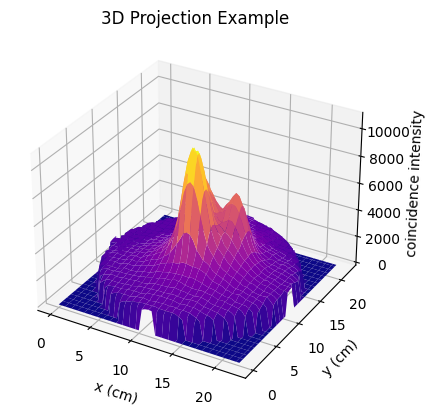

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0,22,len(normalized)) 
y = np.linspace(0,22,len(normalized))
X, Y = np.meshgrid(x, y)

flipped = normalized[::-1] 
ax.plot_surface(X, Y, flipped,cmap='plasma')
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.set_zlabel('coincidence intensity')
ax.set_title('3D Projection Example');